# TensorFlow Causal Impact

## 1. Concepts

The <a href=https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf>Causal Impact</a> model developed by Google works by fitting a Bayesian structural time series model to observed data which is later used for predicting what the results would be had no intervention happened in a given time period, as depicted below:

![./tfcausal_plot_original_example.png](./tfcausal_plot_original_example.png)

The idea is to use the predictions of the fitted model (depicted in orange) as a reference to what probably would had been observed with no intervention taking place.

Bayesian Structural Time Series models can be expressed by the following equations:

<center>$ y_t = Z^T_t\alpha_t + \beta X_t + G_t\epsilon_t$</center>
<center>$ a_{t+1} = T_t\alpha_t + R_t\eta_t$</center>
<center>$\epsilon_t \sim \mathcal{N}(0, \sigma_t^2)$</center>
<center>$\eta_t \sim \mathcal{N}(0, Q_t)$</center>

The $a$ is also referred as a "state" of the series and $y_t$ is a linear combination of the states plus a linear regression with the covariates $X$ (and the measurement noise $\epsilon$ that follows a zero-mean normal distribution).

By varying the matricex $Z$, $T$, $G$ and $R$ we can model several distinct behaviors for the time series (including the more well known such as ARMA or ARIMA).

In this package (the same is true for Google's R package), you can choose any time series model you want to fit your data (more about this later below). If no model is used as input, a local level is built by default, which means $y_t$ is expressed as:

<center>$ y_t = \mu_t + \gamma_t + \beta X_t + \epsilon_t$</center>
<center>$ \mu_{t+1} = \mu_t +  \eta_{\mu, t}$</center>

Any given point in time is modeled first by a random walk component $\mu_t$, also known as the "local level" component, which increases as the other arguments doesn't add much signal into explaining the data (as it models just randomness, there's no information being added with this component except the expectation for greater uncertainty) along with the $\gamma_t$ variable which models seasonal components

Finally we have the component $\beta X_t$ which is a linear regression of covariates that further helps to explain observed data. The better this component works into the prediction task, the lower the local level component should be.

The parameter $\epsilon_t$ models noise related to measuring $y_t$ and it follows a normal distribution with zero mean and $\sigma_{\epsilon}$ standard deviation.

## 2. How to Use This Library

First, let's import and prepare the notebook for the code development environment:

In [1]:
%matplotlib inline

import sys
import os


sys.path.append(os.path.abspath('../'))


import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from causalimpact import CausalImpact


tfd = tfp.distributions
plt.rcParams['figure.figsize'] = [15, 10]

### 2.1 Generating Sample Data

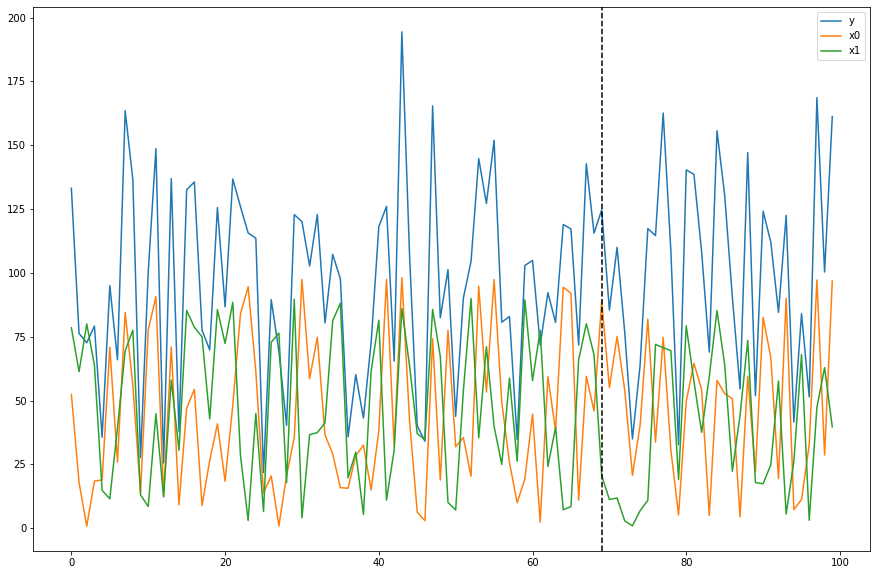

In [51]:
# This is an example presented in Google's R code.
# Uses TensorFlow Probability to simulate a random walk process.
observed_stddev, observed_initial = (tf.convert_to_tensor(value=1, dtype=tf.float32),
                                     tf.convert_to_tensor(value=0., dtype=tf.float32))
level_scale_prior = tfd.LogNormal(loc=tf.math.log(0.05 * observed_stddev), scale=1, name='level_scale_prior')
initial_state_prior = tfd.MultivariateNormalDiag(loc=observed_initial[..., tf.newaxis], scale_diag=(tf.abs(observed_initial) + observed_stddev)[..., tf.newaxis], name='initial_level_prior')
ll_ssm = tfp.sts.LocalLevelStateSpaceModel(100, initial_state_prior=initial_state_prior, level_scale=level_scale_prior.sample())
ll_ssm_sample = np.squeeze(ll_ssm.sample().numpy())

x0 = 100 * np.random.rand(100)
x1 = 90 * np.random.rand(100)
y = 1.2 * x0 + 0.9 * x1 + ll_ssm_sample
y[70:] += 10
data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, columns=['y', 'x0', 'x1'])

data.plot()
plt.axvline(69, linestyle='--', color='k')
plt.legend();

### 2.1 Using Default Model

In [85]:
pre_period = [0, 69]
post_period = [70, 99]
ci = CausalImpact(data, pre_period, post_period)

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


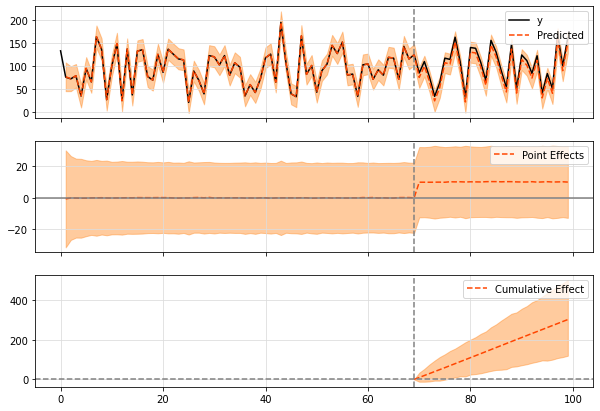

In [53]:
ci.plot()

In [88]:
one_step_dists = tfp.sts.decompose_by_component(ci.model, ci.normed_pre_data.iloc[:, 0].astype(np.float32), ci.model_samples)
forecast_dists = tfp.sts.decompose_forecast_by_component(ci.model, ci.posterior_dist, ci.model_samples)

In [91]:
ci.one_step_dist.mean() * ci.mu_sig[1] + ci.mu_sig[0], ci.one_step_dist.stddev() * ci.mu_sig[1] + ci.mu_sig[0]

(<tf.Tensor: shape=(70,), dtype=float32, numpy=
 array([170.21848 ,  77.455086,  73.059586,  79.601776,  36.52098 ,
         95.38559 ,  66.29642 , 163.01556 , 136.1937  ,  28.445015,
        100.65031 , 148.49759 ,  26.290604, 136.64545 ,  38.46452 ,
        132.14914 , 135.24628 ,  77.62821 ,  70.05534 , 125.269394,
         86.69078 , 136.3691  , 126.08008 , 115.998405, 113.6658  ,
         22.69812 ,  89.50542 ,  69.27395 ,  40.843605, 122.36168 ,
        120.31487 , 102.7939  , 122.886604,  80.665375, 107.210655,
         97.603745,  36.550797,  60.63263 ,  43.896496,  72.82633 ,
        117.94267 , 126.33399 ,  65.84744 , 193.74733 , 106.9497  ,
         40.636673,  34.635605, 164.88235 ,  82.51549 , 101.71023 ,
         44.603382,  90.33275 , 104.39476 , 144.75177 , 127.0034  ,
        151.83286 ,  81.12537 ,  83.10301 ,  35.380806, 102.67039 ,
        104.83848 ,  71.79573 ,  92.55902 ,  80.7812  , 119.14802 ,
        117.49505 ,  71.80853 , 142.3018  , 115.312836, 124.69972 ],

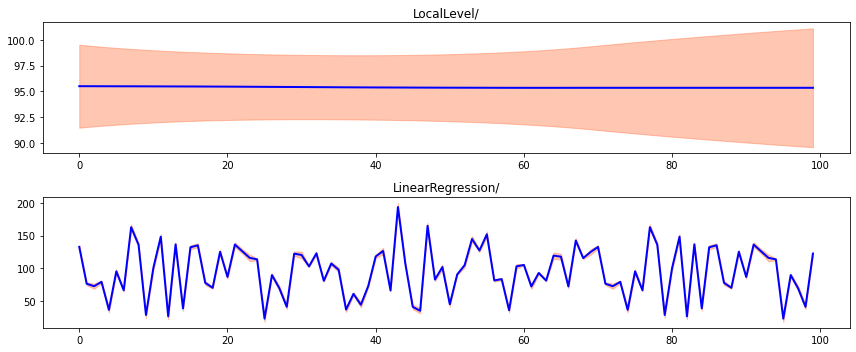

In [89]:
plot_components(ci.pre_data.index.union(ci.post_data.index), one_step_dists, forecast_dists, ci.mu_sig)

When plotting results, three graphics are printed by default:
  - the "original" series versus its predicted one
  - the "points effects" (which is the difference between original series and predicted)
  - finally the "cumulative" effect which is basically the summation of the point effects accumulated over time.

You can choose which pannels to print; here's an example of just the original series and its point-wise effect printed out:

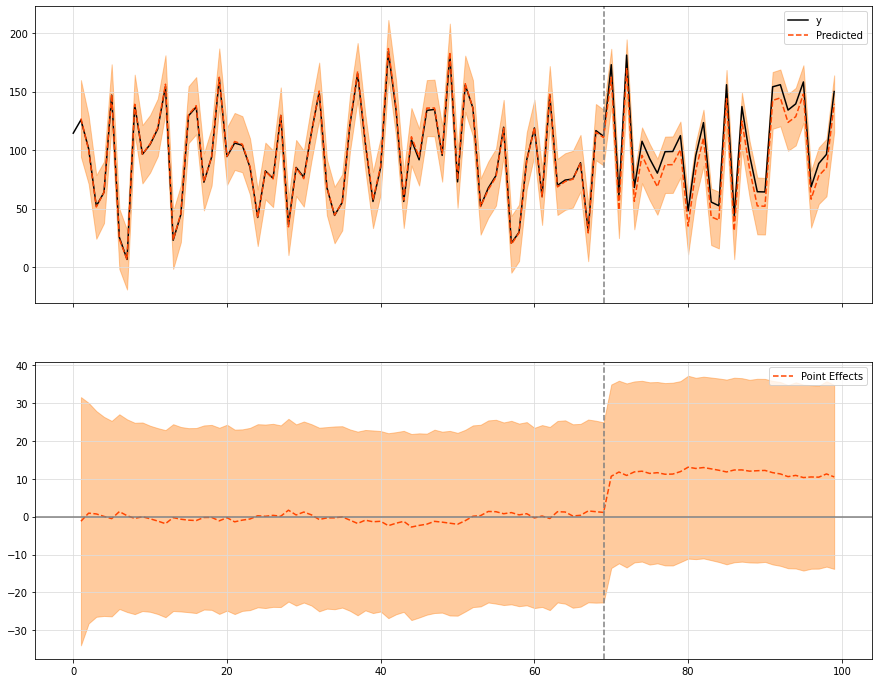

In [5]:
ci.plot(panels=['original', 'pointwise'], figsize=(15, 12))

For also viewing general results and numbers, you can invoke the `summary` method with either default input or "report" which prints a more detailed explanation of the observed effects:

In [7]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    106.01             3180.15
Prediction (s.d.)         96.16 (3.6)        2884.67 (107.86)
95% CI                    [89.16, 103.25]    [2674.67, 3097.47]

Absolute effect (s.d.)    9.85 (3.6)         295.49 (107.86)
95% CI                    [2.76, 16.85]      [82.69, 505.48]

Relative effect (s.d.)    10.24% (3.74%)     10.24% (3.74%)
95% CI                    [2.87%, 17.52%]    [2.87%, 17.52%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.6%

For more details run the command: print(impact.summary('report'))


We can see here for instance that the absolute effect observed is roughly 9 whose predictions varies from 2 up to 15 with 95% confidence interval.

A very important number to also consider when observing these results is the `p-value` or the probability of having a causal effect indeed (and not just noise). Remember to use this value in your analysis before taking conclusions!

If you want a more detailed summary, run the following:

In [8]:
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 106.01. By contrast, in the absence of an
intervention, we would have expected an average response of 96.16.
The 95% interval of this counterfactual prediction is [89.16, 103.25].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 9.85 with a 95% interval of
[2.76, 16.85]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3180.15.
By contrast, had the intervention not taken place, we would have expected
a sum of 2884.67. The 95% interval of this prediction is [2674.67, 3097.47].


The above results are given in terms of absolute numbers. In relative
terms, the response va

The `ci` object also carries all the results of the fitting process, you can access all these values if you want to further analyze results:

In [9]:
ci.inferences.head()

,complete_preds_means,complete_preds_lower,complete_preds_upper,post_preds_means,post_preds_lower,post_preds_upper,post_cum_y,post_cum_preds_means,post_cum_preds_lower,post_cum_preds_upper,point_effects_means,point_effects_lower,point_effects_upper,post_cum_effects_means,post_cum_effects_lower,post_cum_effects_upper
0,67.793678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.934870,NaN,NaN,NaN,NaN,NaN
1,115.244911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.001391,NaN,NaN,NaN,NaN,NaN
2,9.301399,-21.758614,40.361401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.293186,-30.766815,31.353199,NaN,NaN,NaN
3,64.757721,35.928452,93.586990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162147,-28.667123,28.991416,NaN,NaN,NaN
4,143.174042,114.912323,171.435745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.081730,-28.343433,28.179989,NaN,NaN,NaN


You can also retrieve information related to the trained model (such as what were the fitted parameters and so on):

In [10]:
print('Mean value of noise observation std: ', ci.model_samples[0].numpy().mean())
print('Mean value of level std: ', ci.model_samples[1].numpy().mean())
print('Mean value of linear regression x0, x1: ', ci.model_samples[2].numpy().mean(axis=0))

Mean value of noise observation std:  0.28752038
Mean value of level std:  0.009790807
Mean value of linear regression x0, x1:  [0.8361876 0.5434677]


It's also possible to choose a prior value to the standard deviation of the level parameter (or any parameter you'd like to set boundaries to). Here's an example:

In [13]:
ci = CausalImpact(data, pre_period, post_period, model_args={'prior_level_sd':0.1})

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


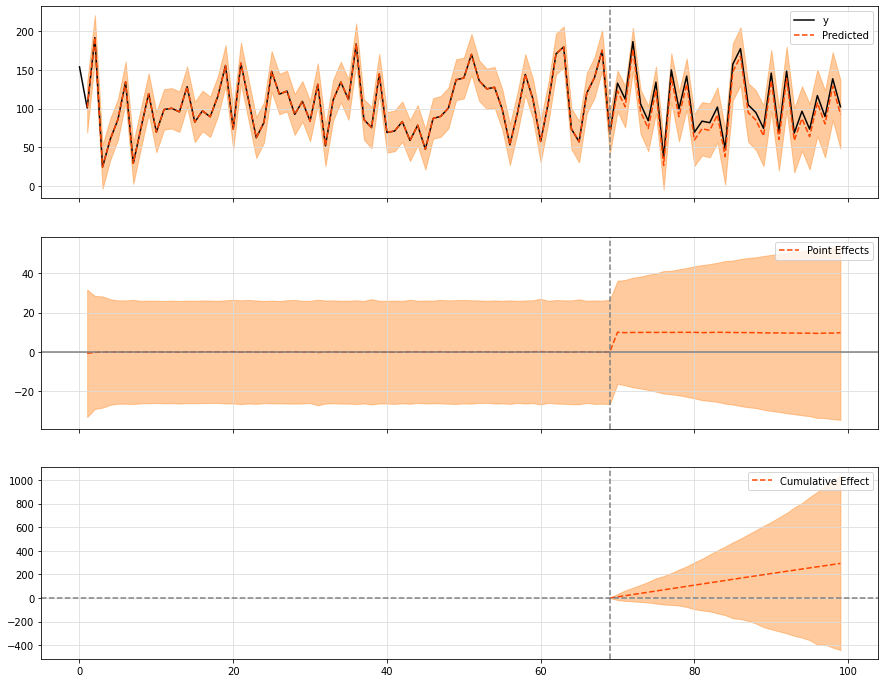

In [14]:
ci.plot(figsize=(15, 12))

Default value is $0.01$ which represents data well behaved with small variance and well explained by the covariates. If it turns out to not to be the case for a given input data, it's possible to change the value on the prior of the local level standard deviation to reflect this pattern in data. For the value $0.1$, we are basically saying that there's a stronger component of a random walk in data that cannot be explained by the covariates themselves.

It's also possible to model season components in data:

In [6]:
observed_stddev, observed_initial = (5., 0.)
num_seasons = 7

drift_scale_prior = tfd.LogNormal(loc=tf.math.log(.01 * observed_stddev), scale=1.)
initial_effect_prior = tfd.Normal(loc=observed_initial, scale=tf.abs(observed_initial) + observed_stddev)
initial_state_prior = tfd.MultivariateNormalDiag(loc=tf.stack([initial_effect_prior.mean()] * num_seasons, axis=-1),
                                                 scale_diag=tf.stack([initial_effect_prior.stddev()] * num_seasons, axis=-1))

s_ssm = tfp.sts.SeasonalStateSpaceModel(
    num_timesteps=100,
    num_seasons=num_seasons,
    num_steps_per_season=1,
    drift_scale=drift_scale_prior.sample(),
    initial_state_prior=initial_state_prior
)

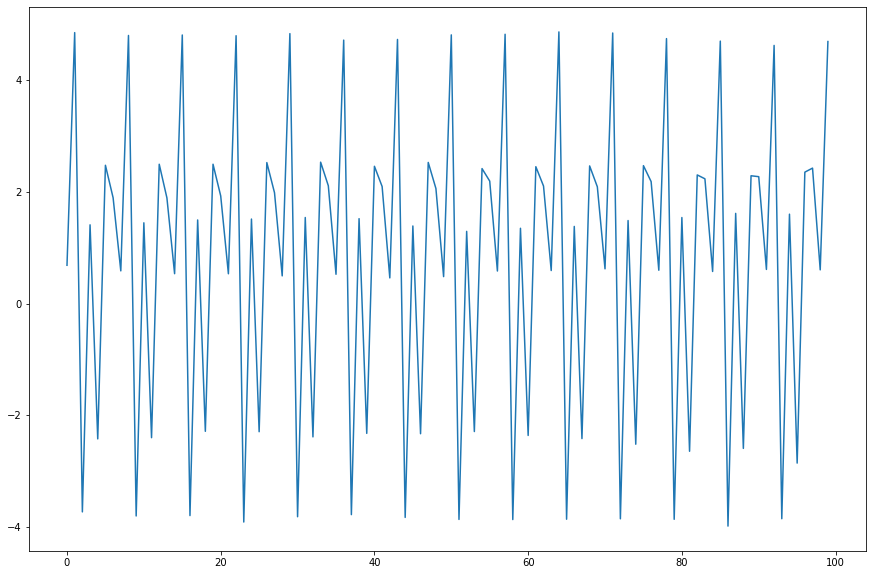

In [14]:
plt.plot(s_ssm.sample());

In [7]:
season_data = data.copy()
season_data['y'] += np.squeeze(s_ssm.sample().numpy())

In [8]:
ci = CausalImpact(season_data, pre_period, post_period, model_args={'nseasons': 7})

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [9]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    103.22             3096.61
Prediction (s.d.)         91.52 (3.48)       2745.52 (104.37)
95% CI                    [84.63, 98.26]     [2538.75, 2947.89]

Absolute effect (s.d.)    11.7 (3.48)        351.09 (104.37)
95% CI                    [4.96, 18.6]       [148.72, 557.85]

Relative effect (s.d.)    12.79% (3.8%)      12.79% (3.8%)
95% CI                    [5.42%, 20.32%]    [5.42%, 20.32%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


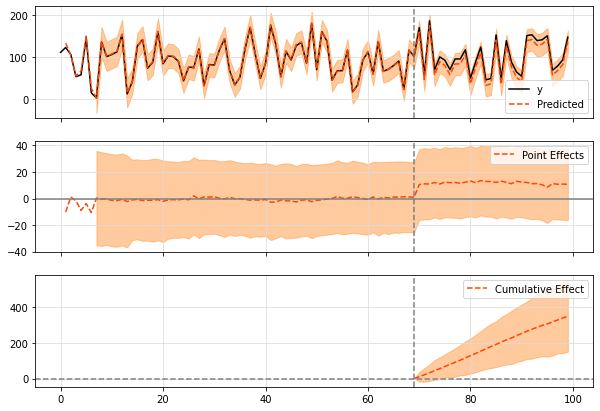

In [10]:
ci.plot()

### 2.2 Working with Dates Index

The model should work with dates as well. Let's see what happens when our input data have a date as index type:

In [11]:
dated_data = data.set_index(pd.date_range(start='20200101', periods=len(data)))

pre_period = ['20200101', '20200311']
post_period = ['20200312', '20200409']

figsize = (20, 6)
ci = CausalImpact(dated_data, pre_period, post_period)

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


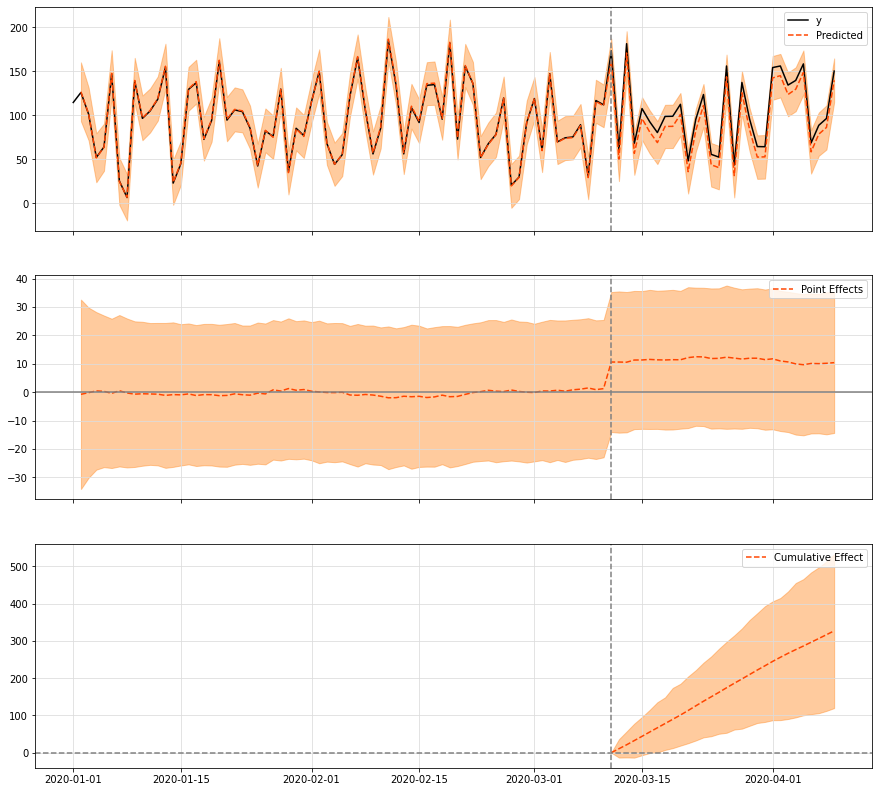

In [12]:
ci.plot(figsize=(15, 14))

In [13]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    102.88             2983.46
Prediction (s.d.)         91.6 (3.59)        2656.37 (104.23)
95% CI                    [84.76, 98.84]     [2457.93, 2866.5]

Absolute effect (s.d.)    11.28 (3.59)       327.09 (104.23)
95% CI                    [4.03, 18.12]      [116.96, 525.53]

Relative effect (s.d.)    12.31% (3.92%)     12.31% (3.92%)
95% CI                    [4.4%, 19.78%]     [4.4%, 19.78%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


### 2.3 Customized Model

Just as in Google R package, here you can also choose a customized model to be trained in the pre-intervention period. It's important to note that if you want to have the data standardized, then your customized model must be built with data already standardized and the input `data` must be the original denormalized data. Also, the model must be built with data of dtype 32 bytes (either np.float32 or tf.float32) as otherwise it may not work when running through TensorFlow):

In [14]:
from causalimpact.misc import standardize


normed_data, _ = standardize(data.astype(np.float32))

obs_data = normed_data.iloc[:70, 0]

linear_level = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)
linear_reg = tfp.sts.LinearRegression(design_matrix=normed_data.iloc[:, 1:].values.reshape(-1, normed_data.shape[1] -1))

model = tfp.sts.Sum([linear_level, linear_reg], observed_time_series=obs_data)

pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period, model=model)

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


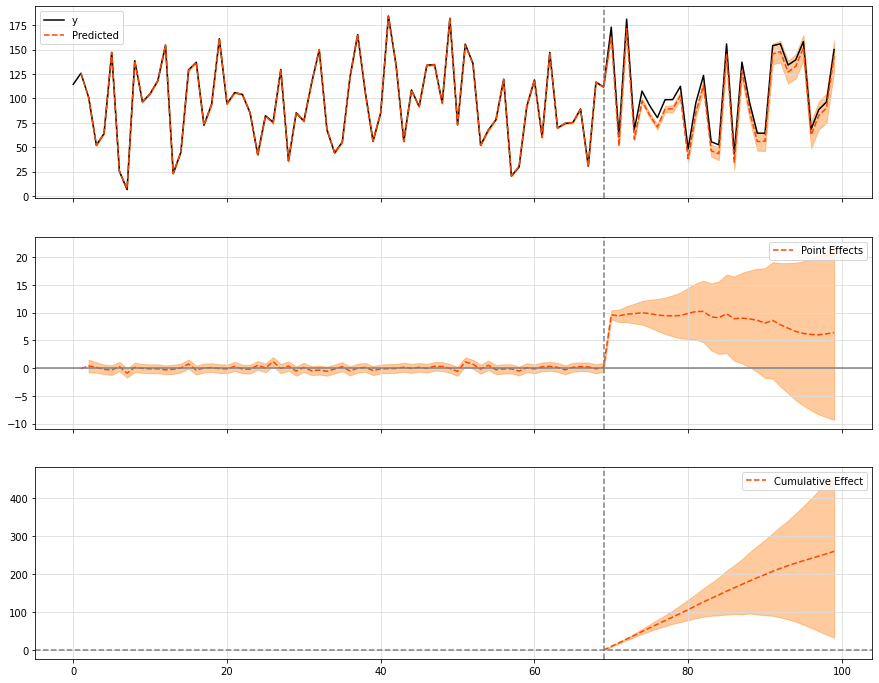

In [15]:
ci.plot(figsize=(15, 12))

In [16]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    105.22             3156.5
Prediction (s.d.)         96.55 (3.71)       2896.63 (111.26)
95% CI                    [90.26, 104.79]    [2707.65, 3143.77]

Absolute effect (s.d.)    8.66 (3.71)        259.86 (111.26)
95% CI                    [0.42, 14.96]      [12.72, 448.84]

Relative effect (s.d.)    8.97% (3.84%)      8.97% (3.84%)
95% CI                    [0.44%, 15.5%]     [0.44%, 15.5%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 97.8%

For more details run the command: print(impact.summary('report'))


### 2.5 Understanding Results

While this is a more sophisticated approach into understanding results from the model, you can print out metrics of the trained model to see why it has fitted the way it has:

In [25]:
dated_data = data.set_index(pd.date_range(start='20200101', periods=len(data)))

pre_period = ['20200101', '20200311']
post_period = ['20200312', '20200409']

ci = CausalImpact(dated_data, pre_period, post_period)

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Remember that the local level model is built by using a noise $\epsilon$, a random walk (level) and the linear regression (beta.X). Sometimes you'll want to see what the values for beta.X are: in case it's too small, then probably the covariate you used in your model is not helping much to explain $y_t$ and you may consider its usefulness into helping to explain the data.

If the model was fit by using the default Hamiltonian method, the end parameters will be a list containing each variable that models the time series. If the method was Variational Inference, then it's a dictionary whose key is the name of the variable and value is the samples obtained in the optimization process.

In [26]:
print('Mean value of noise observation std: ', ci.model_samples[0].numpy().mean())
print('Mean value of level std: ', ci.model_samples[1].numpy().mean())
print('Mean value of linear regression x0, x1: ', ci.model_samples[2].numpy().mean(axis=0))

Mean value of noise observation std:  0.2892443
Mean value of level std:  0.010028366
Mean value of linear regression x0, x1:  [0.8450689 0.5282593]


As we can see, the linear weights helps to explain a lot of what is observed in the response variable. Let's see what happens when we add a total random variable as a covariate to our data:

In [27]:
x2 = pd.DataFrame(np.random.randn(100, 1), columns=['x2'])
data2 = pd.concat([data, x2], axis=1)

In [28]:
pre_period = [0, 69]
post_period = [70, 99]
ci = CausalImpact(data2, pre_period, post_period)

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


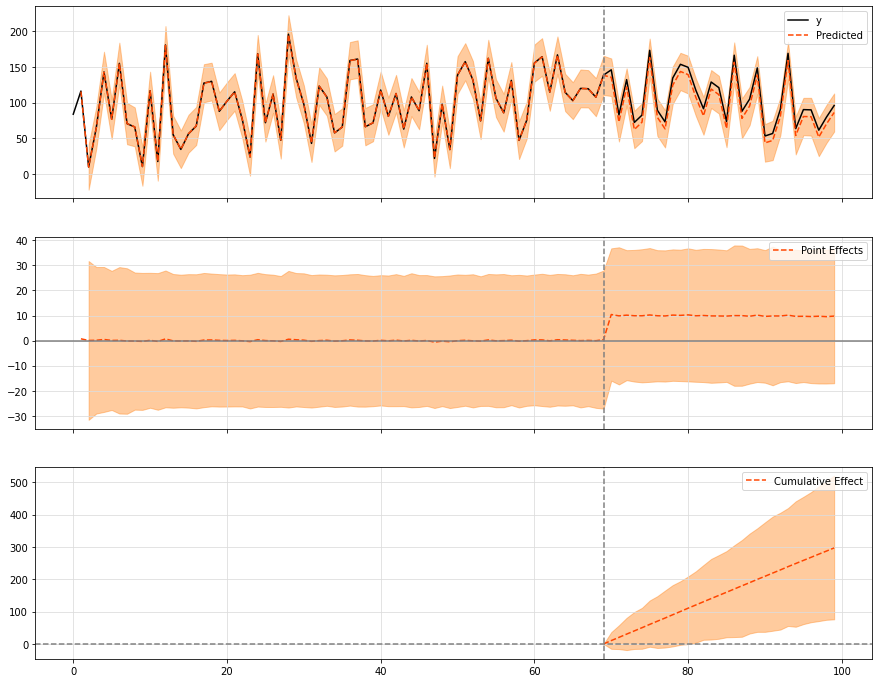

In [29]:
ci.plot(figsize=(15, 12))

In [30]:
print('Mean value of noise observation std: ', ci.model_samples[0].numpy().mean())
print('Mean value of level std: ', ci.model_samples[1].numpy().mean())
print('Mean value of linear regression x0, x1, x2: ', ci.model_samples[2].numpy().mean(axis=0))

Mean value of noise observation std:  0.2909208
Mean value of level std:  0.010190816
Mean value of linear regression x0, x1, x2:  [ 0.83628577  0.5346754  -0.00151107]


$\beta_{x_2}$ doesn't help to explain $y_t$ as we'd expect from a complete random variable with no relationship with the observed data.

Here's now one example with real data:

In [28]:
gdata = pd.read_csv('../tests/fixtures/google_data.csv', index_col='date')

In [29]:
pre_period = ['2020-01-01', '2020-03-01']
post_period = ['2020-03-02', '2020-03-31']

ci = CausalImpact(gdata, pre_period, post_period)

/home/will/Documents/environs/tfci/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


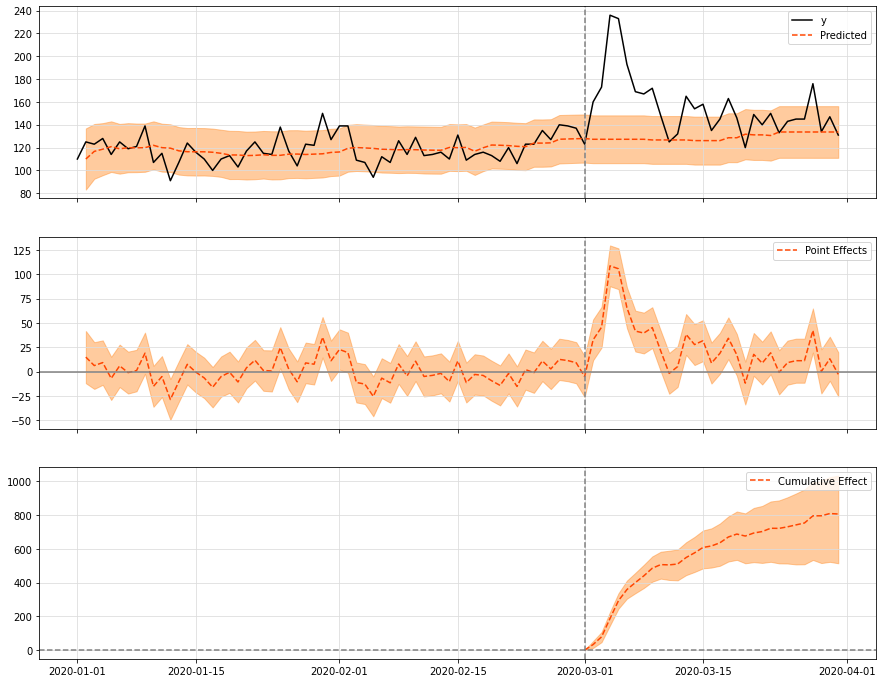

In [30]:
ci.plot(figsize=(15, 12))

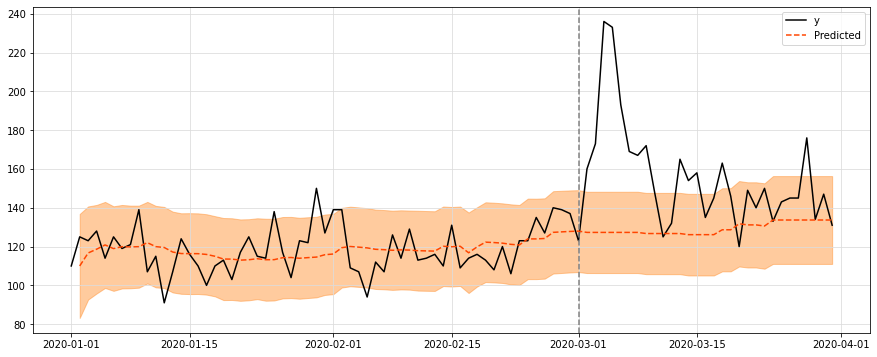

In [31]:
ci.plot(figsize=(15, 6), panels=['original'])

In [21]:
print('Mean value of noise observation std: ', ci.model_samples[0].numpy().mean())
print('Mean value of level std: ', ci.model_samples[1].numpy().mean())
print('Mean value of linear regression x0, x1: ', ci.model_samples[2].numpy().mean(axis=0))

Mean value of noise observation std:  0.8514999
Mean value of level std:  0.010843991
Mean value of linear regression x0, x1:  [ 0.1746452  -0.34230164]


In [22]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    156.23             4687.0
Prediction (s.d.)         126.99 (4.95)      3809.68 (148.59)
95% CI                    [117.4, 136.81]    [3521.88, 4104.35]

Absolute effect (s.d.)    29.24 (4.95)       877.32 (148.59)
95% CI                    [19.42, 38.84]     [582.65, 1165.12]

Relative effect (s.d.)    23.03% (3.9%)      23.03% (3.9%)
95% CI                    [15.29%, 30.58%]   [15.29%, 30.58%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Tensorflow Probability offers a decomposition function that allows us to investigate the state contribution from each component that constitutes the model. We can use this information to create a helper `plot_components` function that plots this information:

In [32]:
one_step_dists = tfp.sts.decompose_by_component(ci.model, ci.pre_data.iloc[:, 0].astype(np.float32), ci.model_samples)
forecast_dists = tfp.sts.decompose_forecast_by_component(ci.model, ci.posterior_dist, ci.model_samples)

In [74]:
ci.mu_sig

(95.40994201987965, 38.26938737989051)

In [75]:
from typing import Dict


def plot_components(index, one_step_dists: Dict[str, tfp.distributions.Distribution],
                    forecast_dists: Dict[str, tfp.distributions.Distribution],
                    mu_sig=None):
    c0, c1 = 'blue', 'orangered'
    num_components = len(one_step_dists)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    mu, sig = mu_sig if mu_sig else (0, 1)
    for i, component in enumerate(one_step_dists.keys()):
        name = component.name
        pre_dist = one_step_dists[component]
        post_dist = forecast_dists[component]
        component_means = np.concatenate([pre_dist.mean(), post_dist.mean()], axis=-1)
        component_stddevs = np.concatenate([pre_dist.stddev(), post_dist.stddev()], axis=-1)
        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(index, component_means * sig + mu, lw=2, c=c0)
        ax.fill_between(index, (component_means - 1.96 * component_stddevs) * sig + mu,
                        (component_means + 1.96 * component_stddevs) * sig + mu,
                        color=c1, alpha=0.3)
        ax.set_title(name)
    fig.tight_layout()
    plt.show()

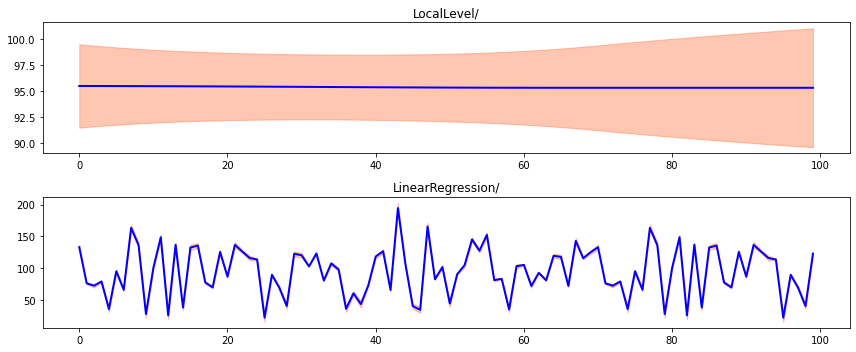

In [76]:
plot_components(ci.pre_data.index.union(ci.post_data.index), one_step_dists, forecast_dists, ci.mu_sig)

The same idea applies to one-step-predictions for pre-intervention data but the function to use should be `tfp.sts.decompose_by_component`.

### 2.6 More Real Data Example

In this section, we'll be working with stock values of three big companies, VolksWagen, BMW And Allianz in order to find what the consequences were for VW after the <a href=https://en.wikipedia.org/wiki/Volkswagen_emissions_scandal>emissions scandal</a> of September 2015 took place.

To beging with, let's load the data:

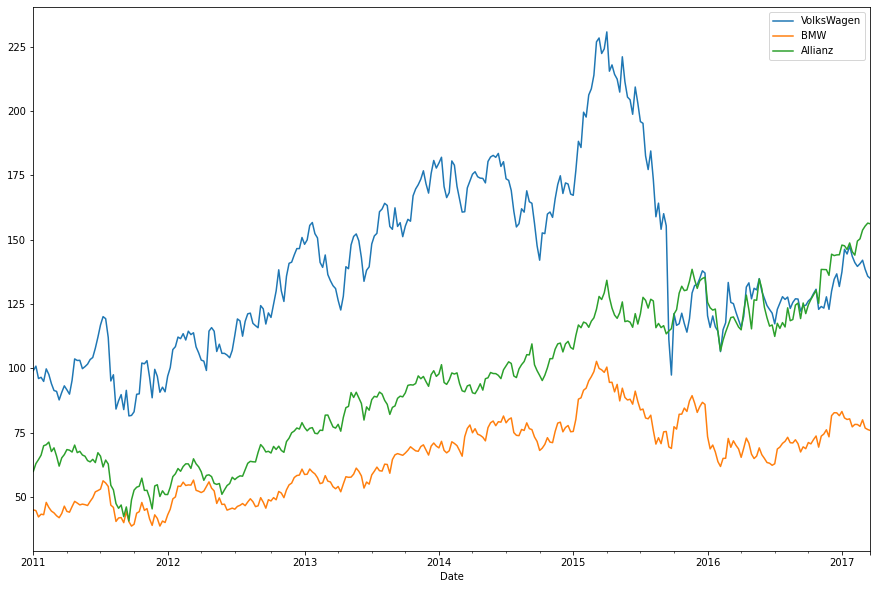

In [3]:
data = pd.read_csv('../tests/fixtures/volks_data.csv', header=0, sep=' ', index_col='Date', parse_dates=True)
data.plot();

In [67]:
data.index

DatetimeIndex(['2011-01-02', '2011-01-09', '2011-01-16', '2011-01-23',
               '2011-01-30', '2011-02-06', '2011-02-13', '2011-02-20',
               '2011-02-27', '2011-03-06',
               ...
               '2017-01-15', '2017-01-22', '2017-01-29', '2017-02-05',
               '2017-02-12', '2017-02-19', '2017-02-26', '2017-03-05',
               '2017-03-12', '2017-03-19'],
              dtype='datetime64[ns]', name='Date', length=325, freq=None)

Let's use `statsmodels` to decompose the data and see if we find meaningful components:

In [ ]:
! pip install statsmodels

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data.loc[:'2015-09-13'].iloc[:, 0])

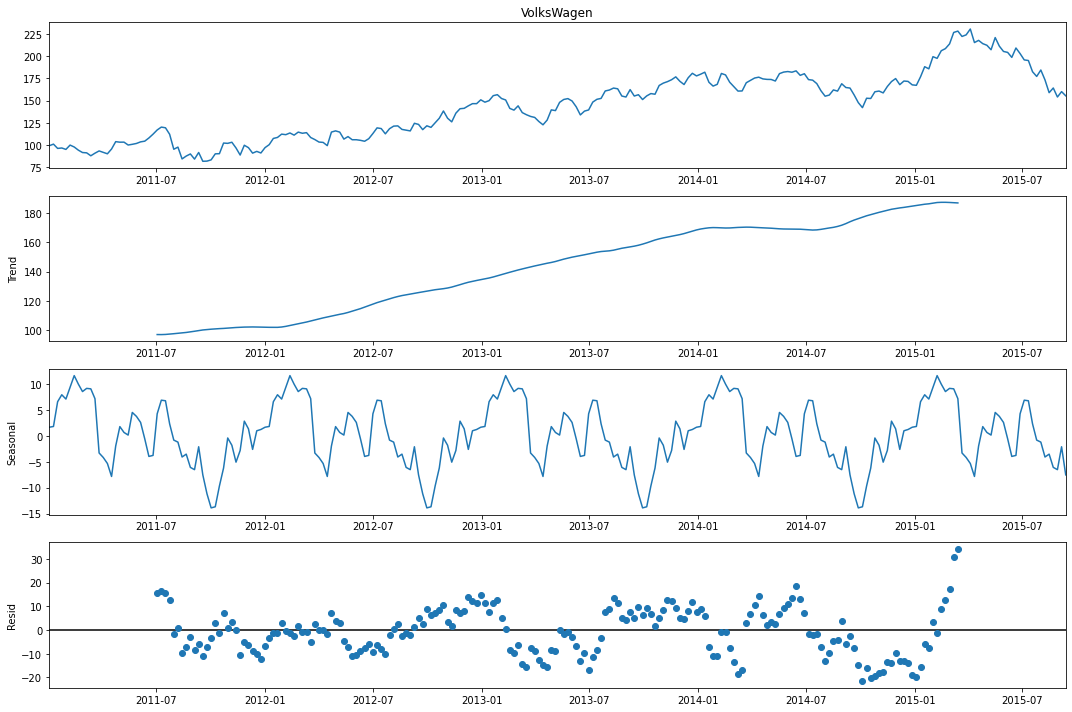

In [66]:
result.plot();

At first, we can see that around September, 2015, VolksWagen stock prices seems to fall abruptly whereas the other series keeps past observed behavior. This seems to indicate we can use both stocks as regressors to help forecasting what VW stocks should be.

First thing we'll do is to run the causal inference considering only the VW stock prices to see what we get (notice we use `vi` for fitting method as otherwise `hmc` only will work on top of a GPU):

In [ ]:
pre_period = [str(np.min(data.index.values)), "2015-09-13"]
post_period = ["2015-09-20", str(np.max(data.index.values))]

ci = CausalImpact(data.iloc[:, 0], pre_period, post_period, model_args={'nseasons': 52, 'fit_method': 'vi'})

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_